In [1]:
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
# only certain models are cleared for model medians
good_models = ['CAM3', 'CAM4', 'CNRM-AM6-DIA-v2', 'CaltechGray', 'ECHAM-6.1',
               'MIROC5', 'MPAS', 'NorESM2']

# pull data from files
try:
    ds            = xr.open_dataset('../data/master.nc')
    ds_fixed      = ds.sel(model=good_models)
    ds_plev       = xr.open_dataset('../data/master_plev.nc')
    ds_plev_fixed = ds_plev.sel(model=good_models)
except FileNotFoundError:
    !python ../modules/loaddata.py

In [3]:
# function to streamline contour generation
tm   = ds_fixed['pr'].mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
pr   = anom.median(dim='model')

tm   = ds_fixed['ts'].mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
ts   = anom.median(dim='model')

# get hex colors
brown = '#6E4007'
blue  = '#124984'

def make_contour(which):
    if which == '_pr':
        c_pr = plt.contour(ds_fixed.lon, np.sin(ds_fixed.lat * np.pi / 180.0), pr, colors=brown, 
                           linestyles='solid', linewidths=3.0, levels=[-0.53])
        # nasty code to remove specific contour lines from plot
        for level in c_pr.collections:
            for kp,path in reversed(list(enumerate(level.get_paths()))):
                verts    = path.vertices
                diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
                if diameter < 100:
                    del(level.get_paths()[kp])      
    elif which == '_ts':
        c_ts = plt.contour(ds_fixed.lon, np.sin(ds_fixed.lat * np.pi / 180.0), ts, colors=blue,
                           linestyles='solid', linewidths=3.0, levels=[-0.5])
        # nasty code to remove specific contour lines from plot
        for level in c_ts.collections:
            for kp,path in reversed(list(enumerate(level.get_paths()))):
                verts    = path.vertices
                diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
                if diameter < 133.73 or diameter > 200:
                    del(level.get_paths()[kp])
    elif which == '_both':
        make_contour('_pr')
        make_contour('_ts')

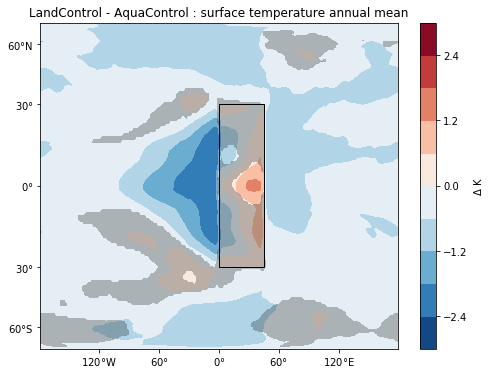

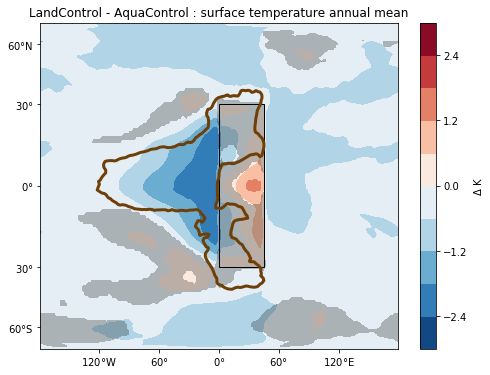

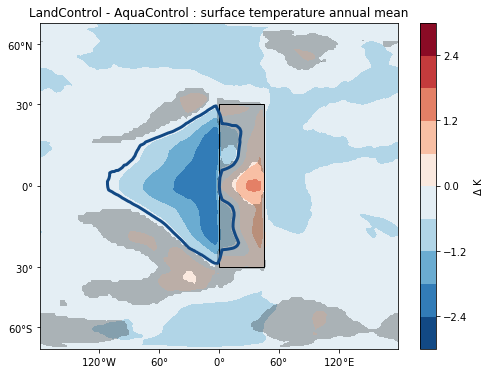

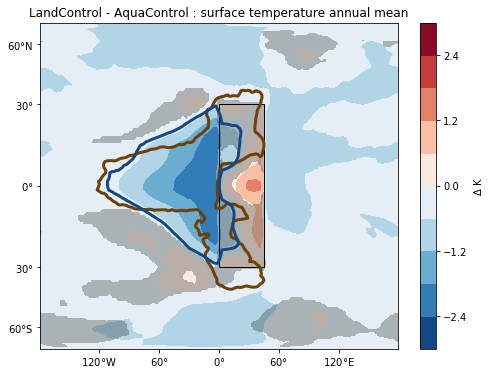

In [4]:
# surface temperature anomalies
tm   = ds_fixed['ts'].dropna(dim='model',how='all').mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
data  = anom.median(dim='model')

# generate agreement masking and contour data
thres = anom.model.size * 3 // 4
agree = np.logical_and((anom < 0).sum(dim='model') <= thres,
                       (anom > 0).sum(dim='model') <= thres)
agree = agree.where(agree == True)

for plot in ['', '_pr', '_ts', '_both']:
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_yticks([-.866, -.5, 0, .5, .866])
    ax.add_patch(Rectangle((0, -.5), 45, 1, alpha=1, facecolor='none',
                           edgecolor='black', linewidth=1.0))

    ax.set_title('LandControl - AquaControl : surface temperature annual mean')
    ax.xaxis.set_ticklabels(['120$\degree$W', '60$\degree$', '0$\degree$', '60$\degree$', '120$\degree$E'])
    ax.yaxis.set_ticklabels(['60$\degree$S', '30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$N'])

    c = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), data, levels=np.linspace(-3.0,3.0,11), cmap='RdBu_r')
    hatch = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), agree, colors='k', alpha=.25)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta$ K')

    make_contour(plot)
    plt.savefig('../figs/LCTL-ACTL_ts_annual' + plot + '.pdf')

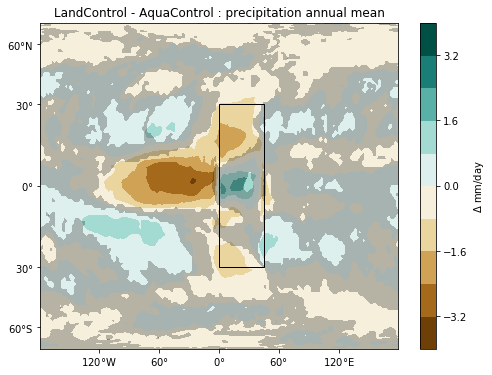

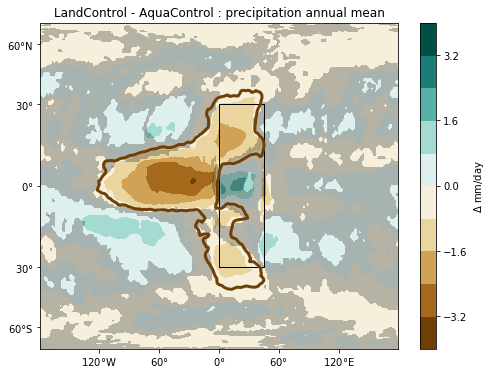

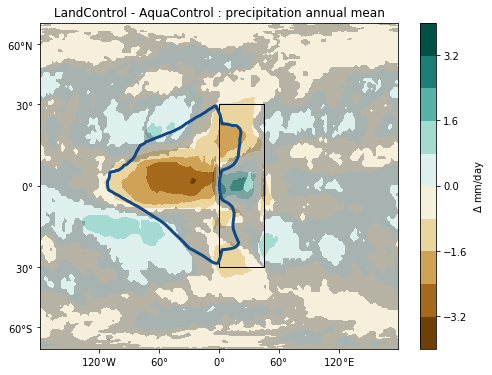

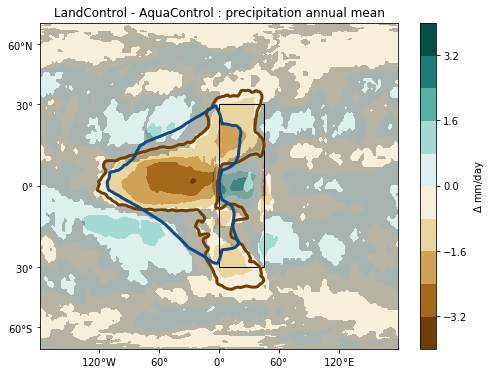

In [5]:
# precipitation anomalies
tm   = ds_fixed['pr'].dropna(dim='model',how='all').mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
data  = anom.median(dim='model')

# generate agreement masking and contour data
thres = anom.model.size * 3 // 4
agree = np.logical_and((anom < 0).sum(dim='model') <= thres,
                       (anom > 0).sum(dim='model') <= thres)
agree = agree.where(agree == True)

for plot in ['', '_pr', '_ts', '_both']:
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_yticks([-.866, -.5, 0, .5, .866])
    ax.add_patch(Rectangle((0, -.5), 45, 1, alpha=1, facecolor='none',
                           edgecolor='black', linewidth=1.0))

    ax.set_title('LandControl - AquaControl : precipitation annual mean')
    ax.xaxis.set_ticklabels(['120$\degree$W', '60$\degree$', '0$\degree$', '60$\degree$', '120$\degree$E'])
    ax.yaxis.set_ticklabels(['60$\degree$S', '30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$N'])

    c = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), data, levels=np.linspace(-4.0,4.0,11), cmap='BrBG')
    hatch = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), agree, colors='k', alpha=.25)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta$ mm/day')

    make_contour(plot)
    plt.savefig('../figs/LCTL-ACTL_pr_annual' + plot + '.pdf')

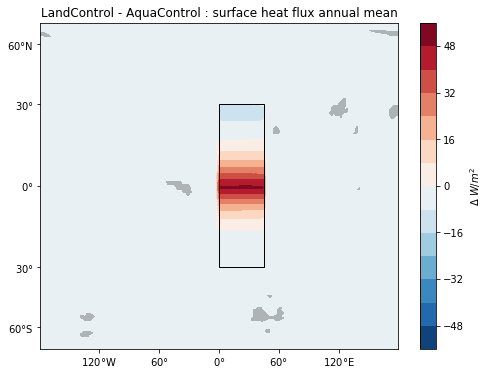

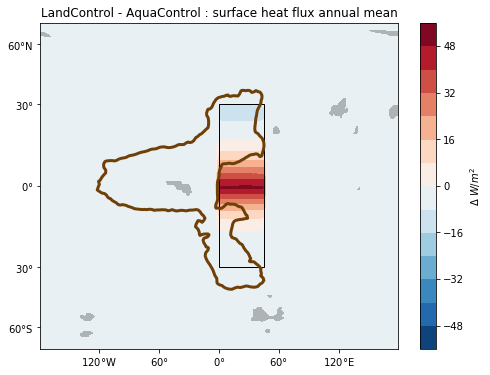

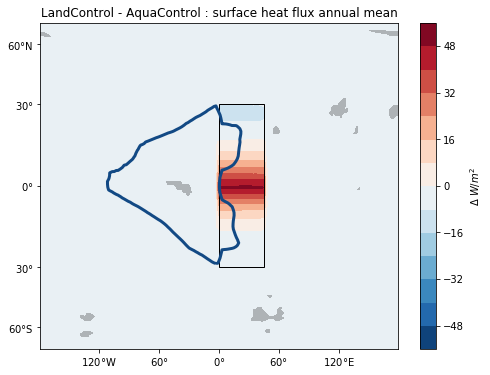

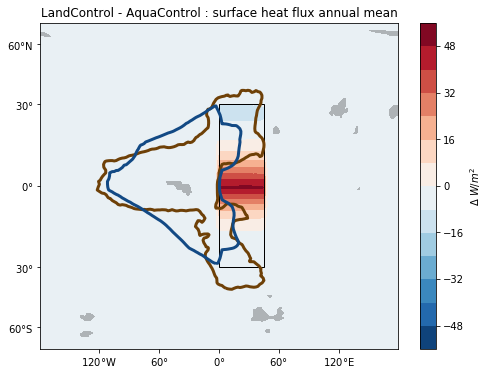

In [6]:
# imposed surface heat flux
tm   = (ds_fixed['rlus'] - ds_fixed['rlds'] +
        ds_fixed['rsus'] - ds_fixed['rsds'] +
        ds_fixed['hfls'] + ds_fixed['hfss']).dropna(dim='model',how='all').mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
data  = anom.median(dim='model')

# generate agreement masking and contour data
thres = anom.model.size * 3 // 4
agree = np.logical_and((anom < 0).sum(dim='model') <= thres,
                       (anom > 0).sum(dim='model') <= thres)
agree = agree.where(agree == True)

for plot in ['', '_pr', '_ts', '_both']:
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_yticks([-.866, -.5, 0, .5, .866])
    ax.add_patch(Rectangle((0, -.5), 45, 1, alpha=1, facecolor='none',
                           edgecolor='black', linewidth=1.0))

    ax.set_title('LandControl - AquaControl : surface heat flux annual mean')
    ax.xaxis.set_ticklabels(['120$\degree$W', '60$\degree$', '0$\degree$', '60$\degree$', '120$\degree$E'])
    ax.yaxis.set_ticklabels(['60$\degree$S', '30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$N'])

    c = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), data, levels=np.linspace(-56,56,15), cmap='RdBu_r')
    hatch = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), agree, colors='k', alpha=.25)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta\ W/m^2$')

    make_contour(plot)
    plt.savefig('../figs/LCTL-ACTL_sflux_annual' + plot + '.pdf')

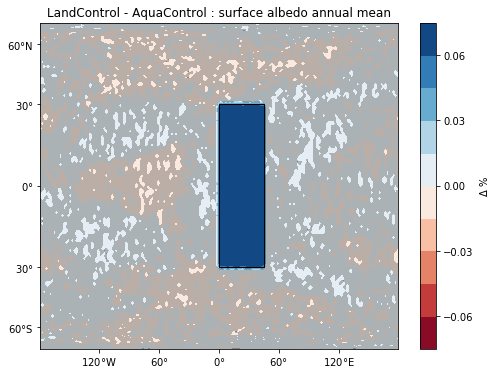

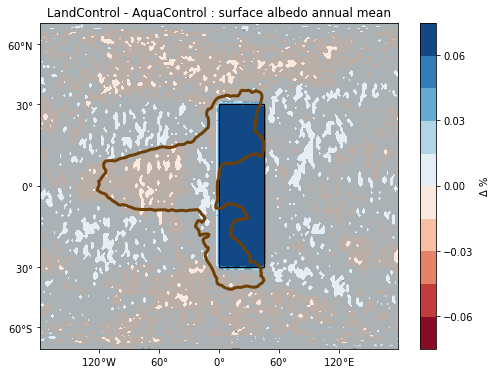

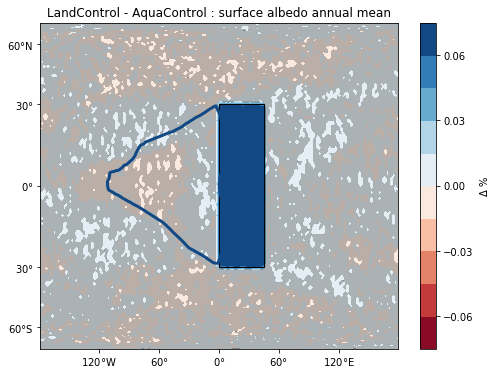

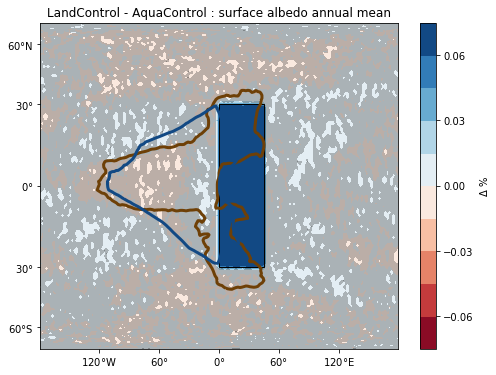

In [7]:
# imposed surface albedo
tm   = (ds_fixed['rsus'] / ds_fixed['rsds']).dropna(dim='model',how='all').mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
data  = anom.median(dim='model')

# generate agreement masking and contour data
thres = anom.model.size * 3 // 4
agree = np.logical_and((anom < 0).sum(dim='model') <= thres,
                       (anom > 0).sum(dim='model') <= thres)
agree = agree.where(agree == True)

for plot in ['', '_pr', '_ts', '_both']:
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_yticks([-.866, -.5, 0, .5, .866])
    ax.add_patch(Rectangle((0, -.5), 45, 1, alpha=1, facecolor='none',
                           edgecolor='black', linewidth=1.0))

    ax.set_title('LandControl - AquaControl : surface albedo annual mean')
    ax.xaxis.set_ticklabels(['120$\degree$W', '60$\degree$', '0$\degree$', '60$\degree$', '120$\degree$E'])
    ax.yaxis.set_ticklabels(['60$\degree$S', '30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$N'])

    c = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), data, levels=np.linspace(-.075,.075,11), cmap='RdBu')
    hatch = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), agree, colors='k', alpha=.25)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta$ %')

    make_contour(plot)
    plt.savefig('../figs/LCTL-ACTL_albedo_annual' + plot + '.pdf')

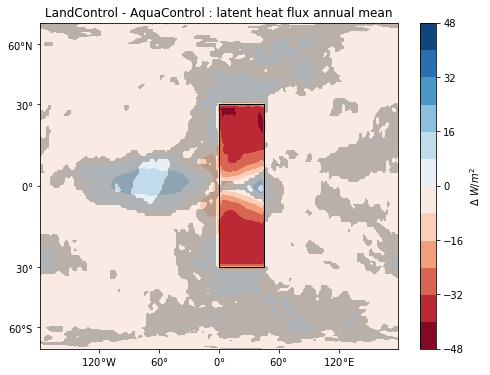

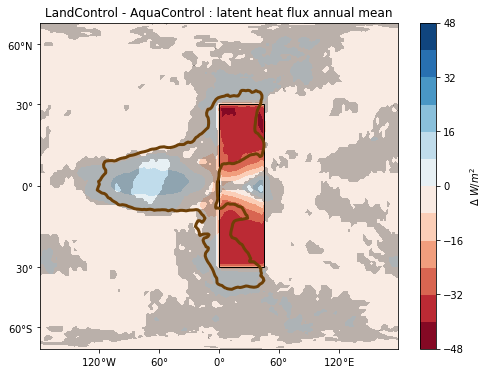

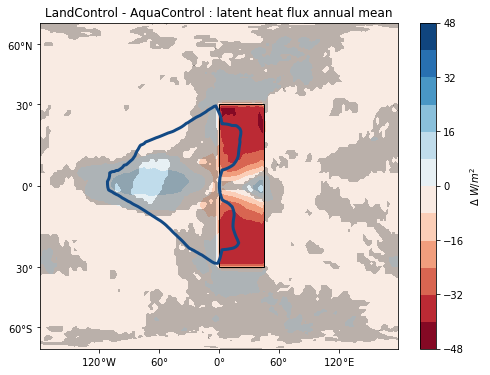

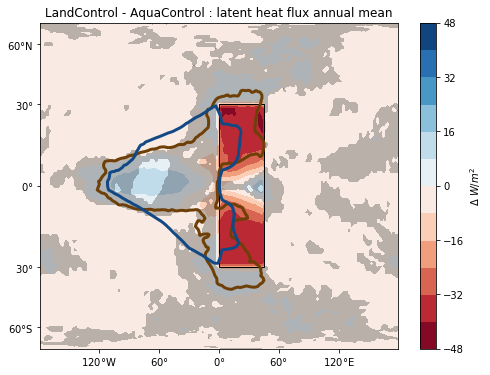

In [8]:
# latent heat flux anomalies
tm   = ds_fixed['hfls'].dropna(dim='model',how='all').mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
data  = anom.median(dim='model')

# generate agreement masking and contour data
thres = anom.model.size * 3 // 4
agree = np.logical_and((anom < 0).sum(dim='model') <= thres,
                       (anom > 0).sum(dim='model') <= thres)
agree = agree.where(agree == True)

for plot in ['', '_pr', '_ts', '_both']:
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_yticks([-.866, -.5, 0, .5, .866])
    ax.add_patch(Rectangle((0, -.5), 45, 1, alpha=1, facecolor='none',
                           edgecolor='black', linewidth=1.0))

    ax.set_title('LandControl - AquaControl : latent heat flux annual mean')
    ax.xaxis.set_ticklabels(['120$\degree$W', '60$\degree$', '0$\degree$', '60$\degree$', '120$\degree$E'])
    ax.yaxis.set_ticklabels(['60$\degree$S', '30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$N'])

    c = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), data, levels=np.linspace(-48,48,13), cmap='RdBu')
    hatch = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), agree, colors='k', alpha=.25)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta\ W/m^2$')

    make_contour(plot)
    plt.savefig('../figs/LCTL-ACTL_hfls_annual' + plot + '.pdf')

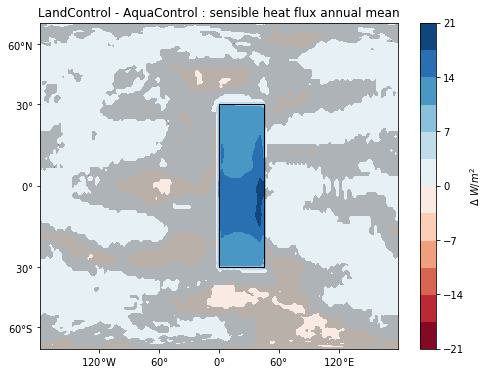

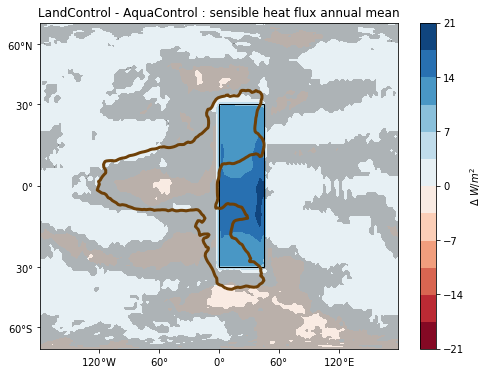

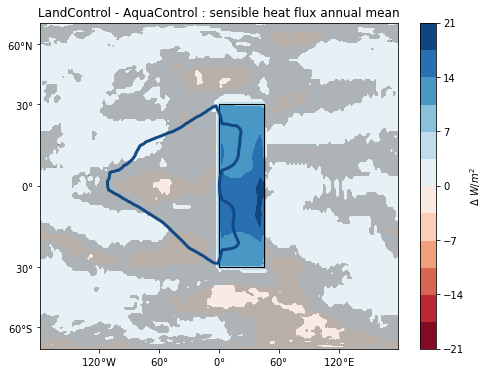

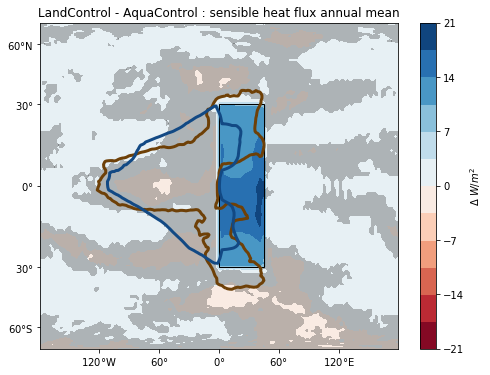

In [9]:
# sensible heat flux anomalies
tm   = ds_fixed['hfss'].dropna(dim='model',how='all').mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
data  = anom.median(dim='model')

# generate agreement masking and contour data
thres = anom.model.size * 3 // 4
agree = np.logical_and((anom < 0).sum(dim='model') <= thres,
                       (anom > 0).sum(dim='model') <= thres)
agree = agree.where(agree == True)

for plot in ['', '_pr', '_ts', '_both']:
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_yticks([-.866, -.5, 0, .5, .866])
    ax.add_patch(Rectangle((0, -.5), 45, 1, alpha=1, facecolor='none',
                           edgecolor='black', linewidth=1.0))

    ax.set_title('LandControl - AquaControl : sensible heat flux annual mean')
    ax.xaxis.set_ticklabels(['120$\degree$W', '60$\degree$', '0$\degree$', '60$\degree$', '120$\degree$E'])
    ax.yaxis.set_ticklabels(['60$\degree$S', '30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$N'])

    c = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), data, levels=np.linspace(-21,21,13),  cmap='RdBu')
    hatch = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), agree, colors='k', alpha=.25)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta\ W/m^2$')

    make_contour(plot)
    plt.savefig('../figs/LCTL-ACTL_hfss_annual' + plot + '.pdf')

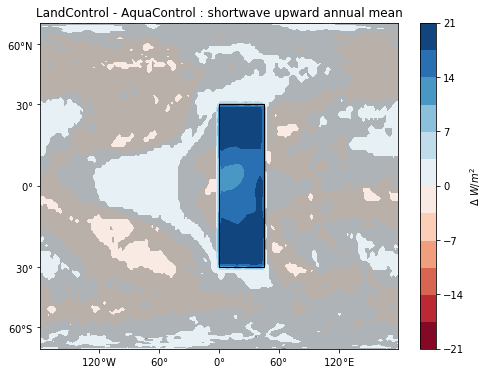

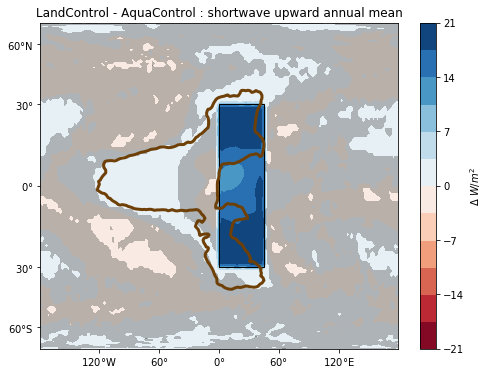

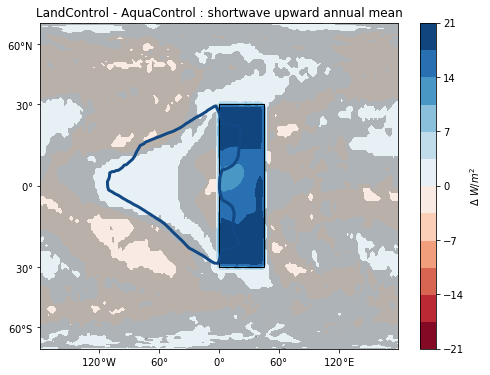

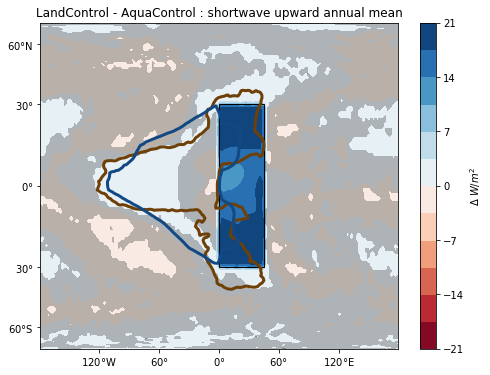

In [10]:
# shortwave upward anomalies
tm   = ds_fixed['rsus'].dropna(dim='model',how='all').mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
data  = anom.median(dim='model')

# generate agreement masking and contour data
thres = anom.model.size * 3 // 4
agree = np.logical_and((anom < 0).sum(dim='model') <= thres,
                       (anom > 0).sum(dim='model') <= thres)
agree = agree.where(agree == True)

for plot in ['', '_pr', '_ts', '_both']:
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_yticks([-.866, -.5, 0, .5, .866])
    ax.add_patch(Rectangle((0, -.5), 45, 1, alpha=1, facecolor='none',
                           edgecolor='black', linewidth=1.0))

    ax.set_title('LandControl - AquaControl : shortwave upward annual mean')
    ax.xaxis.set_ticklabels(['120$\degree$W', '60$\degree$', '0$\degree$', '60$\degree$', '120$\degree$E'])
    ax.yaxis.set_ticklabels(['60$\degree$S', '30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$N'])

    c = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), data, levels=np.linspace(-21,21,13),  cmap='RdBu')
    hatch = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), agree, colors='k', alpha=.25)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta\ W/m^2$')

    make_contour(plot)
    plt.savefig('../figs/LCTL-ACTL_rsus_annual' + plot + '.pdf')

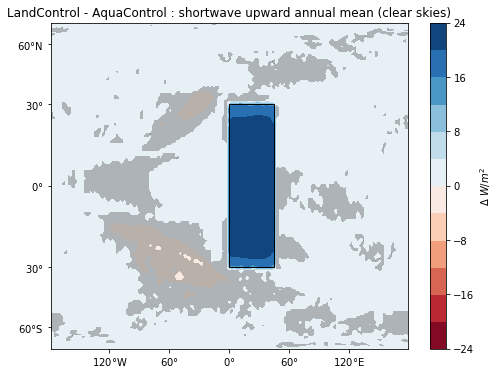

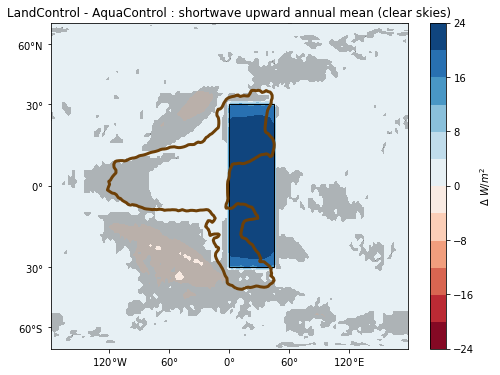

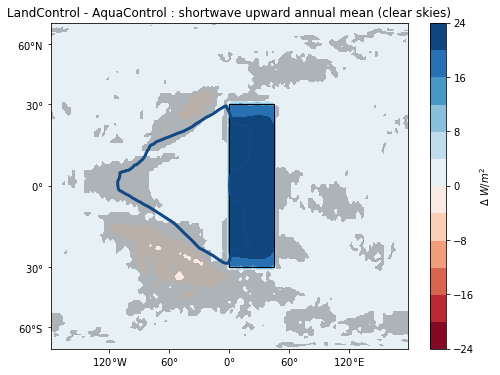

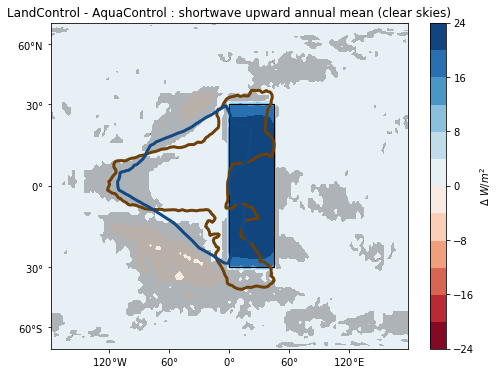

In [11]:
# shortwave upward anomalies (clear skies)
tm   = (ds_fixed['rsuscs']).dropna(dim='model',how='all').mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
data  = anom.median(dim='model')

# generate agreement masking and contour data
thres = anom.model.size * 3 // 4
agree = np.logical_and((anom < 0).sum(dim='model') <= thres,
                       (anom > 0).sum(dim='model') <= thres)
agree = agree.where(agree == True)

for plot in ['', '_pr', '_ts', '_both']:
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_yticks([-.866, -.5, 0, .5, .866])
    ax.add_patch(Rectangle((0, -.5), 45, 1, alpha=1, facecolor='none',
                           edgecolor='black', linewidth=1.0))

    ax.set_title('LandControl - AquaControl : shortwave upward annual mean (clear skies)')
    ax.xaxis.set_ticklabels(['120$\degree$W', '60$\degree$', '0$\degree$', '60$\degree$', '120$\degree$E'])
    ax.yaxis.set_ticklabels(['60$\degree$S', '30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$N'])

    c = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), data, levels=np.linspace(-24,24,13), cmap='RdBu')
    hatch = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), agree, colors='k', alpha=.25)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta\ W/m^2$')

    make_contour(plot)
    plt.savefig('../figs/LCTL-ACTL_rsuscs_annual' + plot + '.pdf')

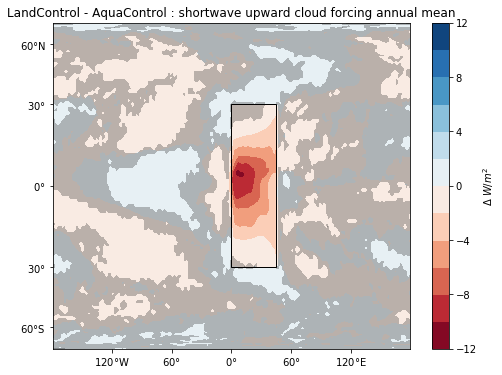

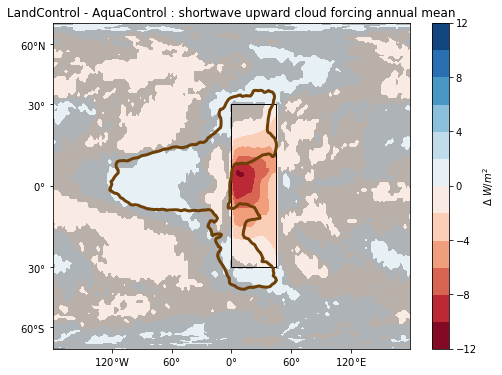

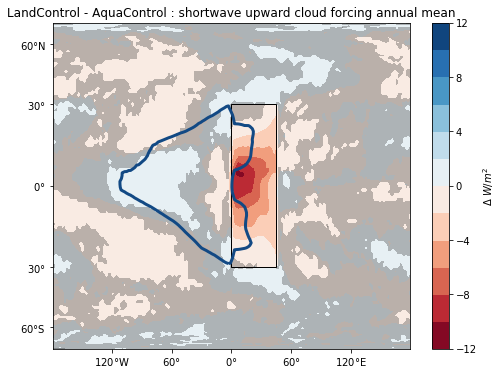

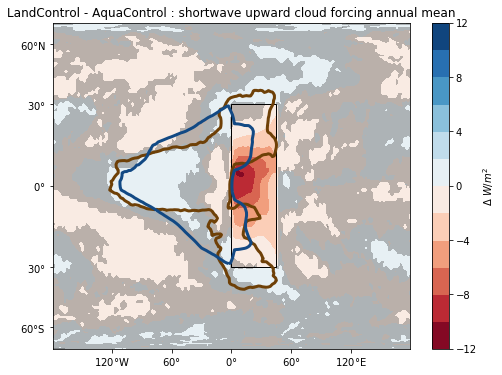

In [12]:
# shortwave upward cloud forcing anomalies
tm   = (ds_fixed['rsus'] - ds_fixed['rsuscs']).dropna(dim='model',how='all').mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
data  = anom.median(dim='model')

# generate agreement masking and contour data
thres = anom.model.size * 3 // 4
agree = np.logical_and((anom < 0).sum(dim='model') <= thres,
                       (anom > 0).sum(dim='model') <= thres)
agree = agree.where(agree == True)

for plot in ['', '_pr', '_ts', '_both']:
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_yticks([-.866, -.5, 0, .5, .866])
    ax.add_patch(Rectangle((0, -.5), 45, 1, alpha=1, facecolor='none',
                           edgecolor='black', linewidth=1.0))

    ax.set_title('LandControl - AquaControl : shortwave upward cloud forcing annual mean')
    ax.xaxis.set_ticklabels(['120$\degree$W', '60$\degree$', '0$\degree$', '60$\degree$', '120$\degree$E'])
    ax.yaxis.set_ticklabels(['60$\degree$S', '30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$N'])

    c = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), data, levels=np.linspace(-12,12,13), cmap='RdBu')
    hatch = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), agree, colors='k', alpha=.25)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta\ W/m^2$')

    make_contour(plot)
    plt.savefig('../figs/LCTL-ACTL_rsus-rsuscs_annual' + plot + '.pdf')

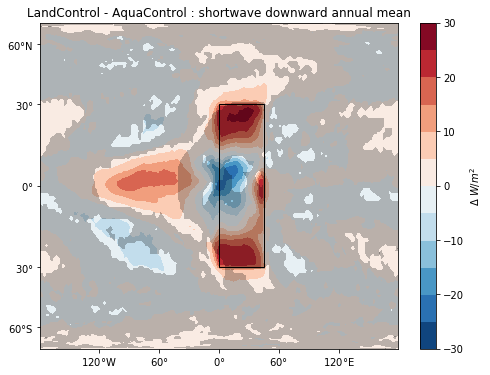

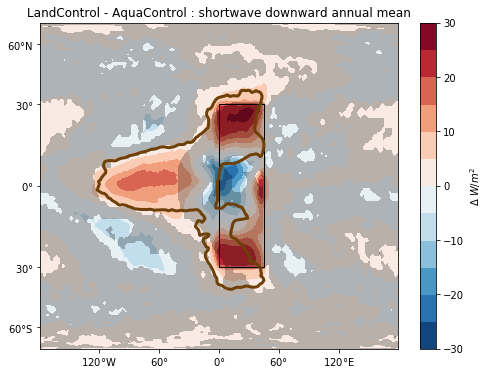

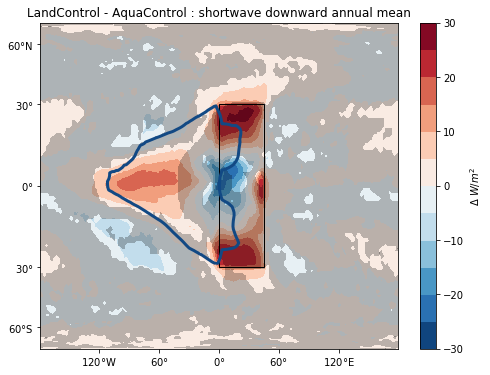

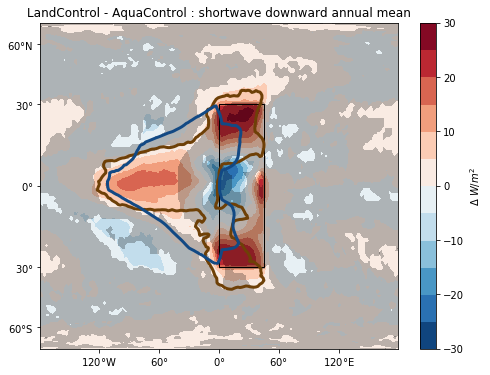

In [13]:
# shortwave downward anomalies
tm   = (ds_fixed['rsds']).dropna(dim='model',how='all').mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
data  = anom.median(dim='model')

# generate agreement masking and contour data
thres = anom.model.size * 3 // 4
agree = np.logical_and((anom < 0).sum(dim='model') <= thres,
                       (anom > 0).sum(dim='model') <= thres)
agree = agree.where(agree == True)

for plot in ['', '_pr', '_ts', '_both']:
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_yticks([-.866, -.5, 0, .5, .866])
    ax.add_patch(Rectangle((0, -.5), 45, 1, alpha=1, facecolor='none',
                           edgecolor='black', linewidth=1.0))

    ax.set_title('LandControl - AquaControl : shortwave downward annual mean')
    ax.xaxis.set_ticklabels(['120$\degree$W', '60$\degree$', '0$\degree$', '60$\degree$', '120$\degree$E'])
    ax.yaxis.set_ticklabels(['60$\degree$S', '30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$N'])

    c = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), data, levels=np.linspace(-30,30,13), cmap='RdBu_r')
    hatch = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), agree, colors='k', alpha=.25)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta\ W/m^2$')

    make_contour(plot)
    plt.savefig('../figs/LCTL-ACTL_rsds_annual' + plot + '.pdf')

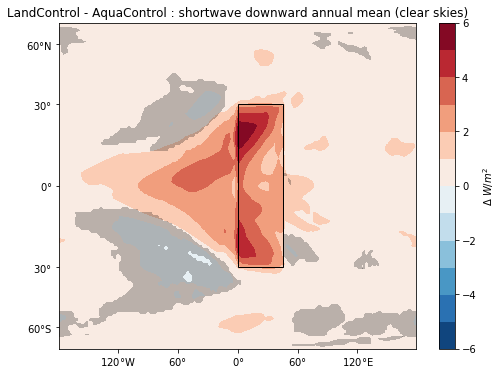

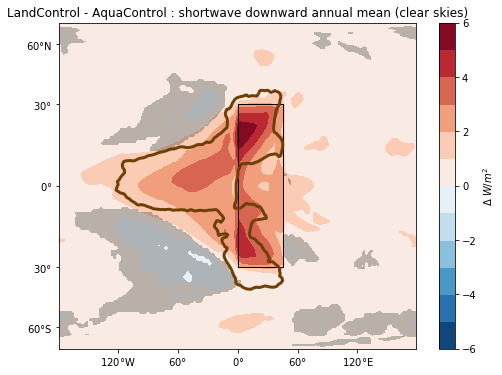

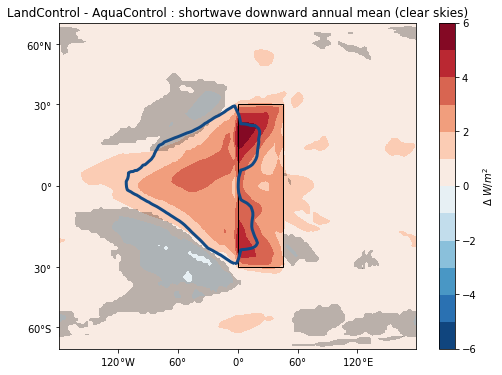

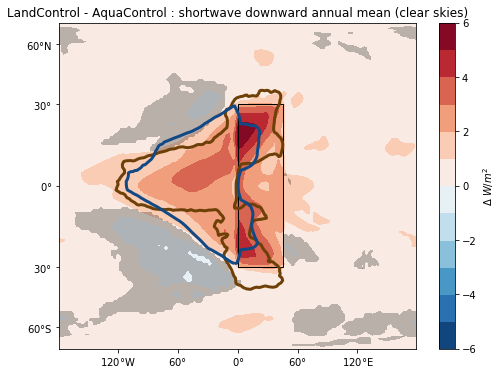

In [14]:
# shortwave downward anomalies (clear skies)
tm   = (ds_fixed['rsdscs']).dropna(dim='model',how='all').mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
data  = anom.median(dim='model')

# generate agreement masking and contour data
thres = anom.model.size * 3 // 4
agree = np.logical_and((anom < 0).sum(dim='model') <= thres,
                       (anom > 0).sum(dim='model') <= thres)
agree = agree.where(agree == True)

for plot in ['', '_pr', '_ts', '_both']:
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_yticks([-.866, -.5, 0, .5, .866])
    ax.add_patch(Rectangle((0, -.5), 45, 1, alpha=1, facecolor='none',
                           edgecolor='black', linewidth=1.0))

    ax.set_title('LandControl - AquaControl : shortwave downward annual mean (clear skies)')
    ax.xaxis.set_ticklabels(['120$\degree$W', '60$\degree$', '0$\degree$', '60$\degree$', '120$\degree$E'])
    ax.yaxis.set_ticklabels(['60$\degree$S', '30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$N'])

    c = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), data, levels=np.linspace(-6,6,13), cmap='RdBu_r')
    hatch = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), agree, colors='k', alpha=.25)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta\ W/m^2$')

    make_contour(plot)
    plt.savefig('../figs/LCTL-ACTL_rsdscs_annual' + plot + '.pdf')

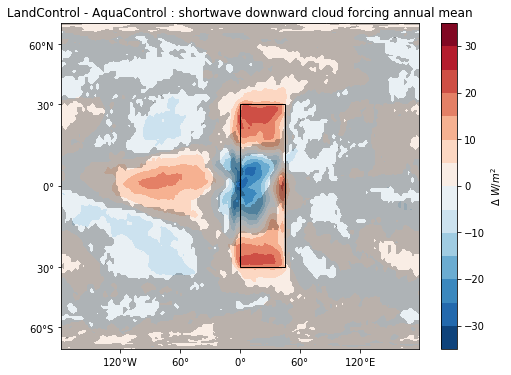

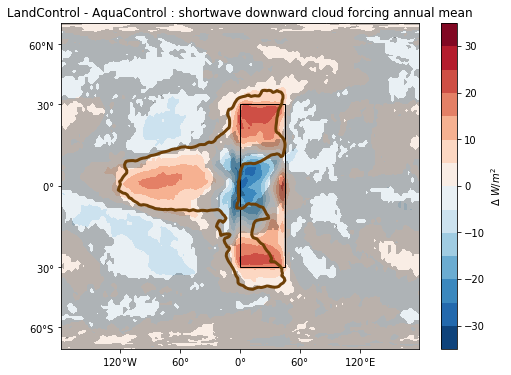

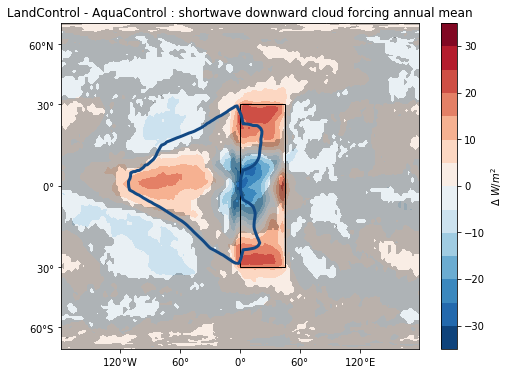

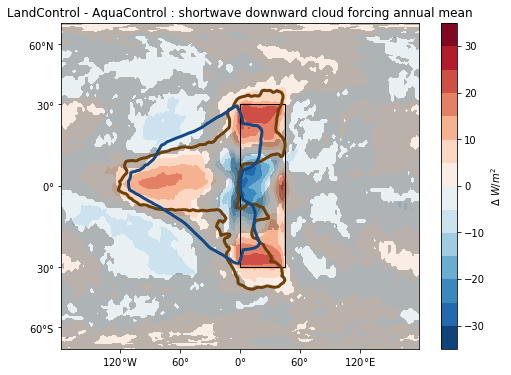

In [15]:
# shortwave downward cloud forcing anomalies
tm   = (ds_fixed['rsds'] - ds_fixed['rsdscs']).dropna(dim='model',how='all').mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
data  = anom.median(dim='model')

# generate agreement masking and contour data
thres = anom.model.size * 3 // 4
agree = np.logical_and((anom < 0).sum(dim='model') <= thres,
                       (anom > 0).sum(dim='model') <= thres)
agree = agree.where(agree == True)

for plot in ['', '_pr', '_ts', '_both']:
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_yticks([-.866, -.5, 0, .5, .866])
    ax.add_patch(Rectangle((0, -.5), 45, 1, alpha=1, facecolor='none',
                           edgecolor='black', linewidth=1.0))

    ax.set_title('LandControl - AquaControl : shortwave downward cloud forcing annual mean')
    ax.xaxis.set_ticklabels(['120$\degree$W', '60$\degree$', '0$\degree$', '60$\degree$', '120$\degree$E'])
    ax.yaxis.set_ticklabels(['60$\degree$S', '30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$N'])

    c = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), data, levels=np.linspace(-35,35,15), cmap='RdBu_r')
    hatch = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), agree, colors='k', alpha=.25)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta\ W/m^2$')

    make_contour(plot)
    plt.savefig('../figs/LCTL-ACTL_rsds-rsdscs_annual' + plot + '.pdf')

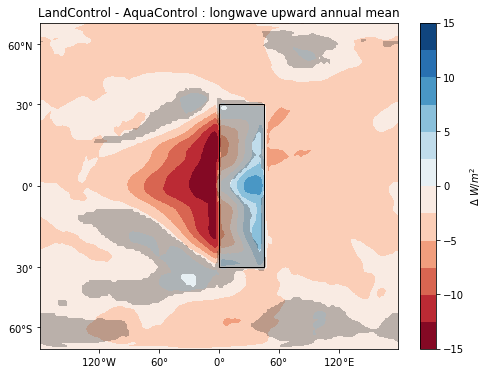

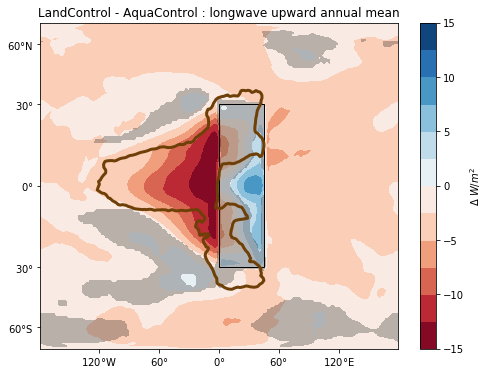

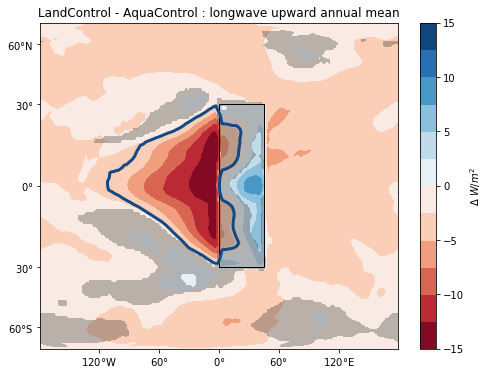

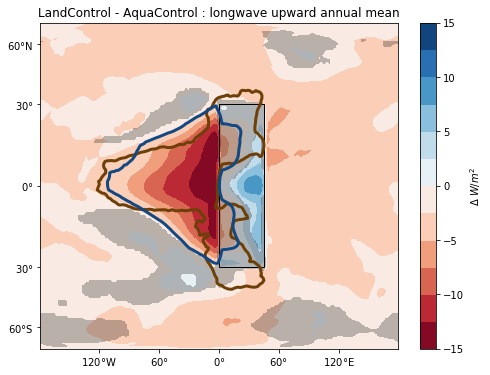

In [16]:
# longwave upward anomalies
tm   = ds_fixed['rlus'].dropna(dim='model',how='all').mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
data  = anom.median(dim='model')

# generate agreement masking and contour data
thres = anom.model.size * 3 // 4
agree = np.logical_and((anom < 0).sum(dim='model') <= thres,
                       (anom > 0).sum(dim='model') <= thres)
agree = agree.where(agree == True)

for plot in ['', '_pr', '_ts', '_both']:
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_yticks([-.866, -.5, 0, .5, .866])
    ax.add_patch(Rectangle((0, -.5), 45, 1, alpha=1, facecolor='none',
                           edgecolor='black', linewidth=1.0))

    ax.set_title('LandControl - AquaControl : longwave upward annual mean')
    ax.xaxis.set_ticklabels(['120$\degree$W', '60$\degree$', '0$\degree$', '60$\degree$', '120$\degree$E'])
    ax.yaxis.set_ticklabels(['60$\degree$S', '30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$N'])

    c = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), data, levels=np.linspace(-15,15,13),  cmap='RdBu')
    hatch = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), agree, colors='k', alpha=.25)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta\ W/m^2$')

    make_contour(plot)
    plt.savefig('../figs/LCTL-ACTL_rlus_annual' + plot + '.pdf')

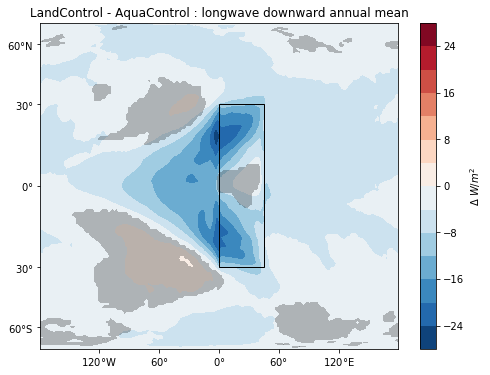

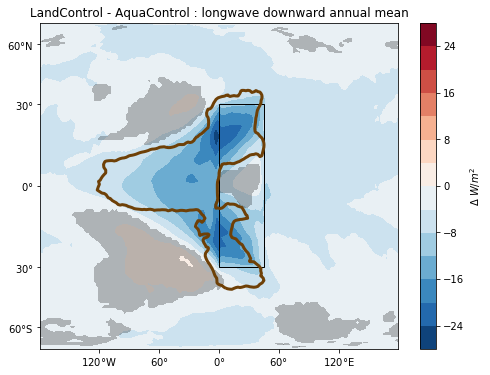

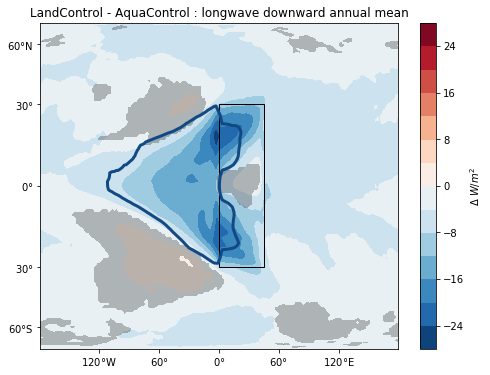

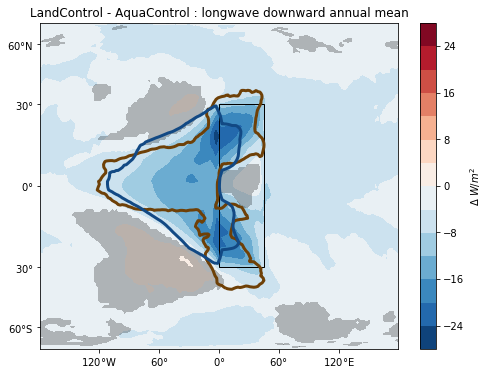

In [17]:
# longwave downward anomalies
tm   = ds_fixed['rlds'].dropna(dim='model',how='all').mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
data  = anom.median(dim='model')

# generate agreement masking and contour data
thres = anom.model.size * 3 // 4
agree = np.logical_and((anom < 0).sum(dim='model') <= thres,
                       (anom > 0).sum(dim='model') <= thres)
agree = agree.where(agree == True)

for plot in ['', '_pr', '_ts', '_both']:
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_yticks([-.866, -.5, 0, .5, .866])
    ax.add_patch(Rectangle((0, -.5), 45, 1, alpha=1, facecolor='none',
                           edgecolor='black', linewidth=1.0))

    ax.set_title('LandControl - AquaControl : longwave downward annual mean')
    ax.xaxis.set_ticklabels(['120$\degree$W', '60$\degree$', '0$\degree$', '60$\degree$', '120$\degree$E'])
    ax.yaxis.set_ticklabels(['60$\degree$S', '30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$N'])

    c = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), data, levels=np.linspace(-28,28,15), cmap='RdBu_r')
    hatch = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), agree, colors='k', alpha=.25)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta\ W/m^2$')

    make_contour(plot)
    #plt.savefig('../figs/LCTL-ACTL_rlds_annual' + plot + '.pdf')

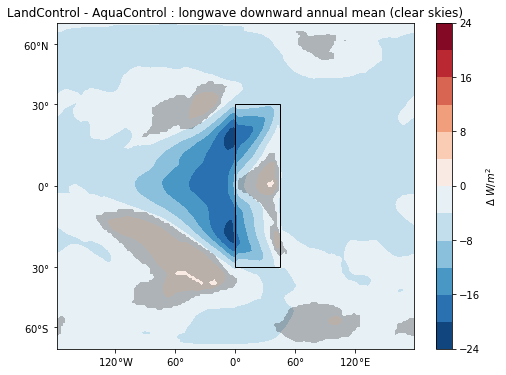

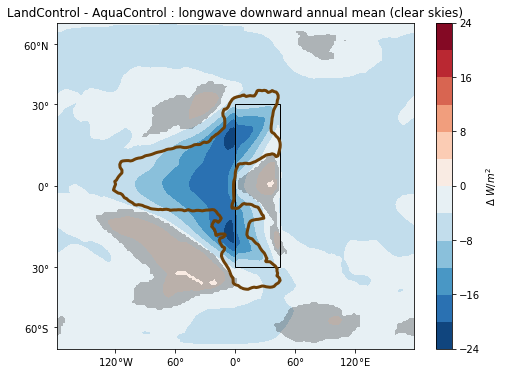

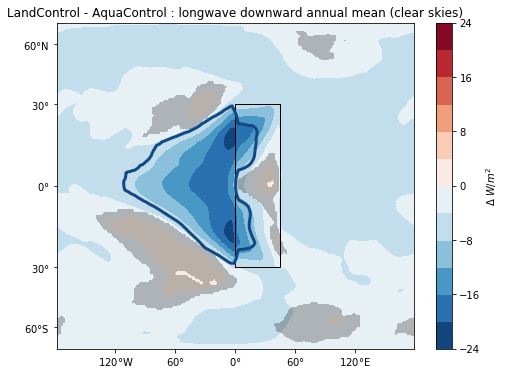

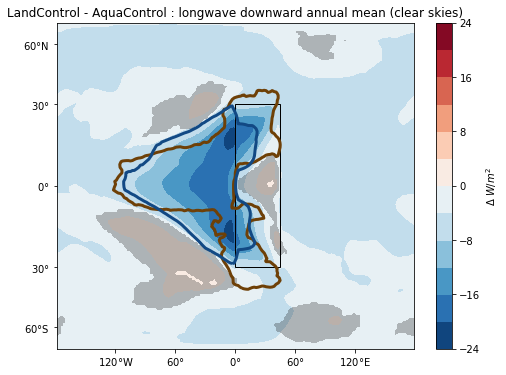

In [18]:
# longwave downward anomalies (clear skies)
tm   = ds_fixed['rldscs'].dropna(dim='model',how='all').mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
data  = anom.median(dim='model')

# generate agreement masking and contour data
thres = anom.model.size * 3 // 4
agree = np.logical_and((anom < 0).sum(dim='model') <= thres,
                       (anom > 0).sum(dim='model') <= thres)
agree = agree.where(agree == True)

for plot in ['', '_pr', '_ts', '_both']:
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_yticks([-.866, -.5, 0, .5, .866])
    ax.add_patch(Rectangle((0, -.5), 45, 1, alpha=1, facecolor='none',
                           edgecolor='black', linewidth=1.0))

    ax.set_title('LandControl - AquaControl : longwave downward annual mean (clear skies)')
    ax.xaxis.set_ticklabels(['120$\degree$W', '60$\degree$', '0$\degree$', '60$\degree$', '120$\degree$E'])
    ax.yaxis.set_ticklabels(['60$\degree$S', '30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$N'])

    c = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), data, levels=np.linspace(-24,24,13), cmap='RdBu_r')
    hatch = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), agree, colors='k', alpha=.25)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta\ W/m^2$')

    make_contour(plot)
    plt.savefig('../figs/LCTL-ACTL_rldscs_annual' + plot + '.pdf')

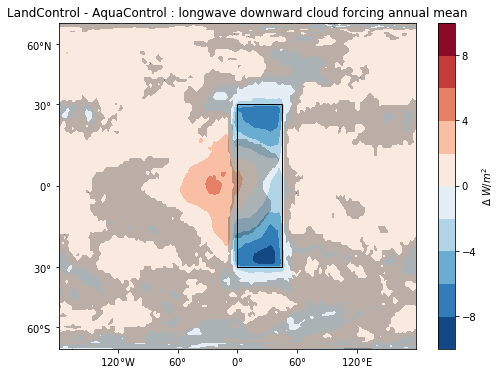

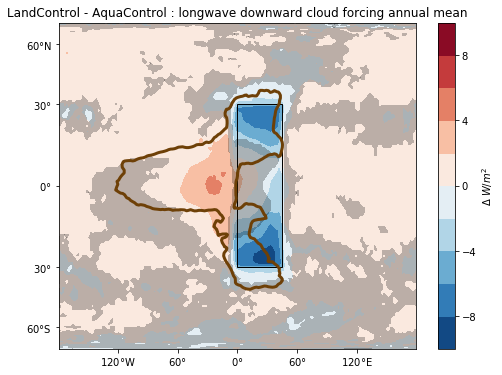

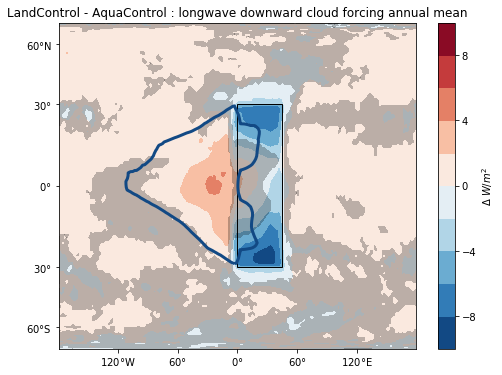

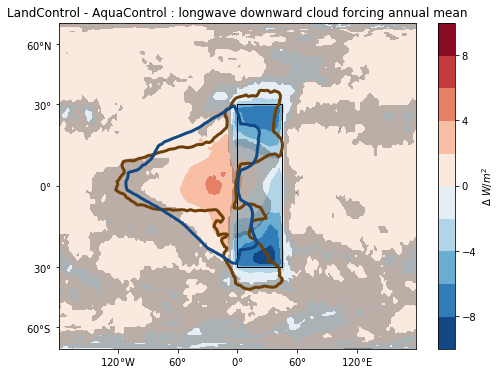

In [19]:
# longwave downward cloud forcing anomalies
tm   = (ds_fixed['rlds'] - ds_fixed['rldscs']).dropna(dim='model',how='all').mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
data  = anom.median(dim='model')

# generate agreement masking and contour data
thres = anom.model.size * 3 // 4
agree = np.logical_and((anom < 0).sum(dim='model') <= thres,
                       (anom > 0).sum(dim='model') <= thres)
agree = agree.where(agree == True)

for plot in ['', '_pr', '_ts', '_both']:
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_yticks([-.866, -.5, 0, .5, .866])
    ax.add_patch(Rectangle((0, -.5), 45, 1, alpha=1, facecolor='none',
                           edgecolor='black', linewidth=1.0))

    ax.set_title('LandControl - AquaControl : longwave downward cloud forcing annual mean')
    ax.xaxis.set_ticklabels(['120$\degree$W', '60$\degree$', '0$\degree$', '60$\degree$', '120$\degree$E'])
    ax.yaxis.set_ticklabels(['60$\degree$S', '30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$N'])

    c = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), data, levels=np.linspace(-10,10,11), cmap='RdBu_r')
    hatch = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), agree, colors='k', alpha=.25)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta\ W/m^2$')

    make_contour(plot)
    plt.savefig('../figs/LCTL-ACTL_rlds-rldscs_annual' + plot + '.pdf')

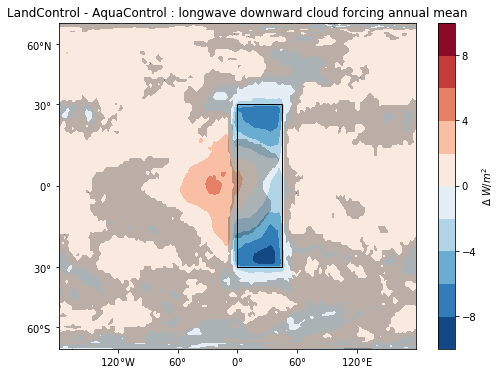

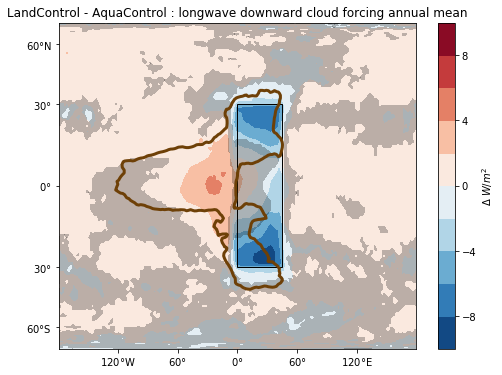

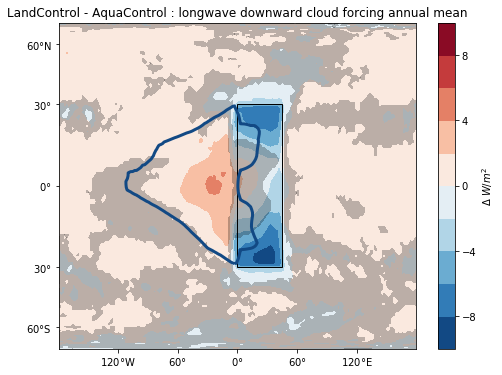

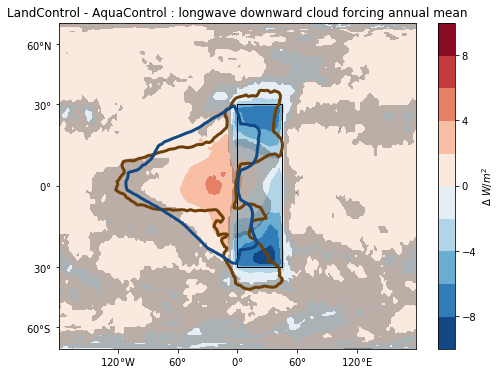

In [20]:
# longwave downward cloud forcing anomalies
tm   = (ds_fixed['rlds'] - ds_fixed['rldscs']).dropna(dim='model',how='all').mean(dim='time')
anom = tm.sel(exp='LandControl') - tm.sel(exp='AquaControl')
data  = anom.median(dim='model')

# generate agreement masking and contour data
thres = anom.model.size * 3 // 4
agree = np.logical_and((anom < 0).sum(dim='model') <= thres,
                       (anom > 0).sum(dim='model') <= thres)
agree = agree.where(agree == True)

for plot in ['', '_pr', '_ts', '_both']:
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_yticks([-.866, -.5, 0, .5, .866])
    ax.add_patch(Rectangle((0, -.5), 45, 1, alpha=1, facecolor='none',
                           edgecolor='black', linewidth=1.0))

    ax.set_title('LandControl - AquaControl : longwave downward cloud forcing annual mean')
    ax.xaxis.set_ticklabels(['120$\degree$W', '60$\degree$', '0$\degree$', '60$\degree$', '120$\degree$E'])
    ax.yaxis.set_ticklabels(['60$\degree$S', '30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$N'])

    c = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), data, levels=np.linspace(-10,10,11), cmap='RdBu_r')
    hatch = plt.contourf(data.lon, np.sin(data.lat * np.pi / 180.0), agree, colors='k', alpha=.25)
    cbar = plt.colorbar(c)
    cbar.set_label('$\Delta\ W/m^2$')

    make_contour(plot)
    plt.savefig('../figs/LCTL-ACTL_rlds-rldscs_annual' + plot + '.pdf')